# Python for Geospatial Plotting

This notebook presents a brief introduction to a variety of geospatial plotting tasks. 

A focus is on working with NetCDF data and point location to generate static, animated, and interactive visualizations. 

**Task 1:** Plot monitoring locations 

- Work with (lat, lon) point data
- Importance of setting coordinate reference system (CRS)
- Use GeoPandas for geospatial-aware tables
- Utilize remote data sources for basemaps

**Task 2:** Create maps from remote NetCDF data

- Import and explore remote NetCDF datasets
- Build a Delaunay triangulation using dataset variables
- Plot the Delaunery triangulation: water currents and water depth
- Plot a time series of water currents as
  - A sequence of subplots
  - An animated gif

**Task 3:** Plot time series data for point locations

- Given target coordinates, find nearest coordinates in NetCDF dataset
- Extract time series data from NetCDF into Pandas dataframe
- By specifying a datetime index, take advantage of Panda's time series tools

**Task 4:** Plot points on an interactive map

- Use folium to create an interactive map
- Can use mouse to zoom, click on points for additional info, etc
- Save the visualization as an HTML file that can be shared on the web


**Source:** Some of the NetCDF material heavily borrowed from: http://rsignell-usgs.github.io/blog/blog/2014/01/08/fvcom/


## Setup

In [ ]:
from google.colab.output import eval_js

In [ ]:
eval_js('google.colab.output.setIframeHeight("100")')  # Shrink the output cell height

# Python libraries not installed by default in Google Colab
!pip install geopandas
!pip install contextily

# Install a linux program for creating the animated gif
!apt-get update
!apt install imagemagick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.5 MB/s 
     |████████████████████████████████| 16.7 MB 40.4 MB/s 
     |████████████████████████████████| 6.3 MB 35.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ub

In [ ]:
import netCDF4
import datetime as dt
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.tri as Tri
import numpy as np
import folium

**Options**

In [ ]:
# Path to ocean model forecast outputs
nc_url = "http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc"

# Forecast hours to plot
hours_to_plot = [6, 12, 18, 24]

## Task 1: Plot monitoring locations

Here we generate this dataset manually, but it could be loaded from a Shapefile

**Define locations**

In [ ]:
# Locations to plot
coords = [
    (42.318379, -70.981872),
    (42.303915, -70.924786),
    (42.354937, -70.970408),
    (42.330314, -70.935119),
]

# Define the coordinate system of these coordinates 
coords_crs = "EPSG:4326" # This is a code for `WGS 84`, the longitude/latitude system based on Earth's curvature

Convert to geospatial dataframe using `GeoPandas`

In [ ]:
# Explicity store the (lat, lon) coordinates as Point data
coords_ = [Point((coord[1], coord[0])) for coord in coords]
names = ["station {}".format(i) for i in range(len(coords_))]

c = {
    "Name" : names,
    "geometry" : coords_,
}

# Store as a spatial dataframe
gdf_stations = gpd.GeoDataFrame(c, crs=coords_crs)

gdf_stations

Name                    geometry
0  station 0  POINT (-70.98187 42.31838)
1  station 1  POINT (-70.92479 42.30392)
2  station 2  POINT (-70.97041 42.35494)
3  station 3  POINT (-70.93512 42.33031)

**Plot the points**

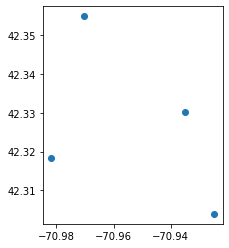

In [ ]:
gdf_stations.plot()

**Plot the points on a base map**

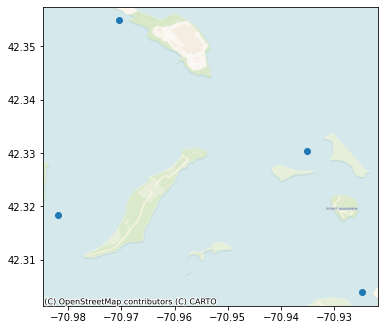

In [ ]:
# Initialize figure
fig, ax = plt.subplots(figsize=(6, 6))

gdf_stations.plot(ax=ax)

# Add basemap using 'con
cx.add_basemap(ax, 
               crs=gdf_stations.crs.to_string(),      # Automatically set crs using our geo dataframe
               source=cx.providers.CartoDB.Voyager, # Many options for the basemap 
               )

**Calculate a bounding box for the points**

- Useful to know a geographic rectangle that contains the points
- Can add some padding to avoid the points being right in the edge

In [ ]:
# Extract the latitudes, longitudes separately
lons = [(geo.x) for geo in gdf_stations["geometry"].values]
lats = [(geo.y) for geo in gdf_stations["geometry"].values]

padding_degrees = 0.01 

def getBounds(x, y, padding):
  # Given 'x', 'y' coordinates and a padding distance,
  # calculate a bounding box

  # Calculate boundary points
  lower_left = Point((min(x) - padding_degrees, min(y) - padding_degrees))
  upper_left = Point((min(x) - padding_degrees, max(y) + padding_degrees))
  lower_right = Point((max(x) + padding_degrees, min(y) - padding_degrees))
  upper_right = Point((max(x) + padding_degrees, max(y) + padding_degrees))

  # We return the dictionary that could be used to make a geodataframe,
  # but stop short of doing so to make the function more generic
  # This way: (1) do not require pandas/geopandas, (2) do not require crs
  return {
      "bounds" : ["lower_left", "upper_left", "lower_right", "upper_right"],
      "geometry" : [lower_left, upper_left, lower_right, upper_right]
  }

bounds = getBounds(lons, lats, padding_degrees)

gdf_bounds = gpd.GeoDataFrame(bounds, 
                              crs=gdf_stations.crs.to_string())

gdf_bounds

bounds                    geometry
0   lower_left  POINT (-70.99187 42.29392)
1   upper_left  POINT (-70.99187 42.36494)
2  lower_right  POINT (-70.91479 42.29392)
3  upper_right  POINT (-70.91479 42.36494)

**Plot the boundary points**

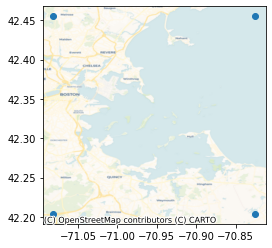

In [ ]:
fig, ax = plt.subplots()
gdf_bounds.plot(ax=ax)
cx.add_basemap(ax, crs=gdf_bounds.crs.to_string(), source=cx.providers.CartoDB.Voyager)

**Add the stations, with invisible boundary points**

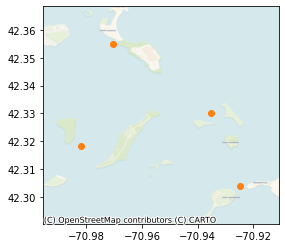

In [ ]:
fig, ax = plt.subplots()
gdf_bounds.plot(ax=ax, alpha=0.0)
gdf_stations.plot(ax=ax)
cx.add_basemap(ax, crs=gdf_bounds.crs.to_string(), source=cx.providers.CartoDB.Voyager)

## Task 2: Create maps from remote NetCDF data

Given a remote data source, do the following:

1. Plot a single map with multiple variables
2. Plot a time-series as an animation

**Load dataset from remote source**

In [ ]:
nc = netCDF4.Dataset(nc_url)

**Investigate dataset content**

First, plot some of the very basic metadata. 

Besides giving potentially useful info, always good to make sure you loaded what you were expecting to load. 

In [ ]:
nc.title

'NECOFS Massachusetts (FVCOM) - Massachusetts Coastal - Latest Forecast'

In [ ]:
initial_time

cftime.DatetimeGregorian(2022, 10, 3, 0, 0, 0, 0, has_year_zero=False)

In [ ]:
# Access first element in the time data array
initial_time = nc["time"][:][0]
# Convert this numeric time code to an understandable Datetime object
initial_time = netCDF4.num2date(initial_time, nc["time"].units)

# Access last element in the time data array
final_time = nc["time"][:][-1]
final_time = netCDF4.num2date(final_time, nc["time"].units)

# Print with a specific format
print("Initial forecast time: ", initial_time.strftime('%Y-%b-%d %H:%M'))
print("Final forecast time:", final_time.strftime('%Y-%b-%d %H:%M'))

Initial forecast time:  2022-Oct-03 00:00
Final forecast time: 2022-Oct-09 00:00


Print all the variables & their metadata

The output has a lot of important information about the dimensions, units, etc. But is a little messy. 

In [ ]:
eval_js('google.colab.output.setIframeHeight("350")')  # Shrink the output cell height

nc_vars = nc.variables

var_names = [str(var) for var in nc_vars]

print("List of variables in NetCDF dataset:")
print(var_names)
print("\n\n")

print("Metadata for each variable:\n")
for var in nc_vars:
  print(nc_vars[var])
  print("\n")

List of variables in NetCDF dataset:
['x', 'y', 'lon', 'lat', 'xc', 'yc', 'lonc', 'latc', 'siglay', 'h', 'nv', 'time', 'Times', 'zeta', 'nbe', 'aw0', 'awx', 'awy', 'u', 'v', 'ww', 'ua', 'va', 'temp', 'salinity', 'fvcom_mesh']



Metadata for each variable:

<class 'netCDF4._netCDF4.Variable'>
float32 x(node)
    long_name: nodal x-coordinate
    units: meters
unlimited dimensions: 
current shape = (98432,)
filling off


<class 'netCDF4._netCDF4.Variable'>
float32 y(node)
    long_name: nodal y-coordinate
    units: meters
unlimited dimensions: 
current shape = (98432,)
filling off


<class 'netCDF4._netCDF4.Variable'>
float32 lon(node)
    long_name: nodal longitude
    standard_name: longitude
    units: degrees_east
unlimited dimensions: 
current shape = (98432,)
filling off


<class 'netCDF4._netCDF4.Variable'>
float32 lat(node)
    long_name: nodal latitude
    standard_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (98432,)
filling off


<class 'net

Query metadata for a specific variable

In [ ]:
var = "x"

if var in nc_vars:
  print(nc_vars["x"])
else:
  print("Could not find variable '{}' in dataset".format(var))

Could not find variable 'hello' in dataset


**Convert time offsets to specific timestamps**

In [ ]:
timestamps = [initial_time + dt.timedelta(hours=hour) for hour in hours_to_plot]
timestamps

[cftime.DatetimeGregorian(2022, 10, 3, 6, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2022, 10, 3, 12, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2022, 10, 3, 18, 0, 0, 0, has_year_zero=False),
 cftime.DatetimeGregorian(2022, 10, 4, 0, 0, 0, 0, has_year_zero=False)]

**Convert first timestep to a numeric code that matches the NetCDF 'time' variable**

In [ ]:
itime = netCDF4.date2index(timestamps[0], 
                           nc["time"], 
                           select="nearest"  # The dataset has a discrete set of times. This lets you get the nearest time to what you request
                           )

**Get the delauney triangle network**

In [ ]:
# Get coordinates for nodes
lat = nc["lat"][:]
lon = nc["lon"][:]

# Get coordinates for cell centers
latc = nc['latc'][:]
lonc = nc['lonc'][:]

# Get Connectivity array
nv = nc['nv'][:].T - 1 

# Build triangulation
tri = Tri.Triangulation(lon,lat, triangles=nv)

**Find indices of coordinates within our geographic bounding box**

In [ ]:
bbox_idxs = np.argwhere((lonc >= float(gdf_bounds[gdf_bounds["bounds"] == "lower_left"]["geometry"].x)) & \
                     (lonc <= float(gdf_bounds[gdf_bounds["bounds"] == "lower_right"]["geometry"].x)) & \
                     (latc >= float(gdf_bounds[gdf_bounds["bounds"] == "lower_left"]["geometry"].y)) & \
                     (latc <= float(gdf_bounds[gdf_bounds["bounds"] == "upper_left"]["geometry"].y)))

**Get the variables that are represented by that network**

In [ ]:
# Get depth (bathymetry)
h = nc['h'][:]  # depth

# Get water currents
surface_currents_idx = 0   # Data has currents through water column, 0 at the top
u = nc['u'][itime, surface_currents_idx, :]
v = nc['v'][itime, surface_currents_idx, :]

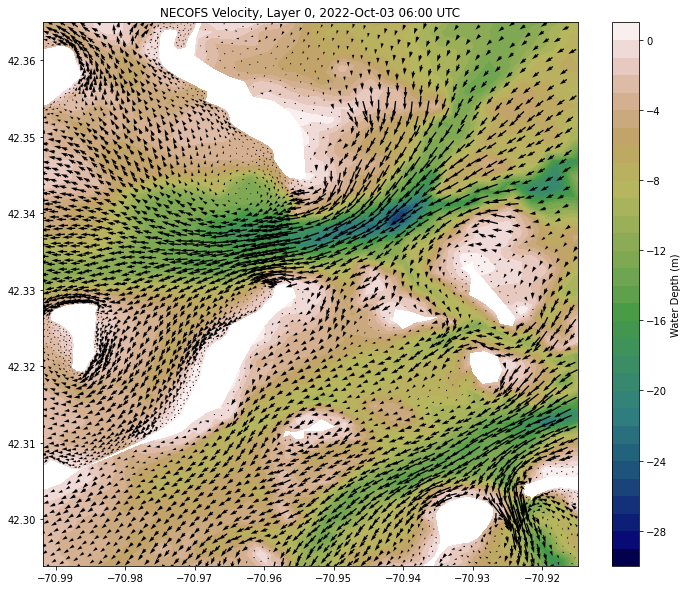

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

ax.set_ylim(float(gdf_bounds[gdf_bounds["bounds"] == "lower_left"]["geometry"].y), float(gdf_bounds[gdf_bounds["bounds"] == "upper_left"]["geometry"].y))
ax.set_xlim(float(gdf_bounds[gdf_bounds["bounds"] == "lower_left"]["geometry"].x), float(gdf_bounds[gdf_bounds["bounds"] == "lower_right"]["geometry"].x))

levels=np.arange(-30,2,1)

cf = ax.tricontourf(tri, -h, cmap=plt.cm.gist_earth, levels=levels)
cbar=plt.colorbar(cf)
cbar.set_label('Water Depth (m)')
Q = ax.quiver(lonc[bbox_idxs], latc[bbox_idxs], u[bbox_idxs], v[bbox_idxs], scale=20)
ax.set_title('NECOFS Velocity, Layer %d, %s UTC' % (surface_currents_idx, timestamps[0].strftime('%Y-%b-%d %H:%M')));

### Plot a sequence of time steps

Task: Given a list of time steps, plot the map (depth & water currents)

1. Put the above plotting code in a function
2. Populate subplot content in a loop

**Define function to plot a map, given a timestamp**

In [ ]:
def plotMap(itime, ax):

  dtime = netCDF4.num2date(nc.variables["time"][itime], nc.variables["time"].units)
  daystr = dtime.strftime('%Y-%b-%d %H:%M')
    
  # Get water current at timestamp
  u = nc['u'][itime, surface_currents_idx, :]
  v = nc['v'][itime, surface_currents_idx, :]

  # Set bounds
  ax.set_ylim(float(gdf_bounds[gdf_bounds["bounds"] == "lower_left"]["geometry"].y), float(gdf_bounds[gdf_bounds["bounds"] == "upper_left"]["geometry"].y))
  ax.set_xlim(float(gdf_bounds[gdf_bounds["bounds"] == "lower_left"]["geometry"].x), float(gdf_bounds[gdf_bounds["bounds"] == "lower_right"]["geometry"].x))

  # Add depth contours
  levels=np.arange(-30,2,1)
  cf = ax.tricontourf(tri, -h, cmap=plt.cm.gist_earth, levels=levels)
  # cbar=plt.colorbar(cf)
  # cbar.set_label('Water Depth (m)')

  # Add water currents
  Q = ax.quiver(lonc[bbox_idxs], latc[bbox_idxs], u[bbox_idxs], v[bbox_idxs], scale=20)

  # Title
  ax.set_title('NECOFS Velocity, Layer %d, %s UTC' % (surface_currents_idx, dtime.strftime('%Y-%b-%d %H:%M')));

  return cf


**Test with a single plot**

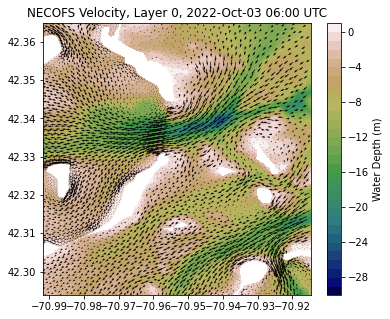

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
cf = plotMap(itime, ax)
cbar=plt.colorbar(cf)
cbar.set_label('Water Depth (m)')

**Plot a timestamp sequence**

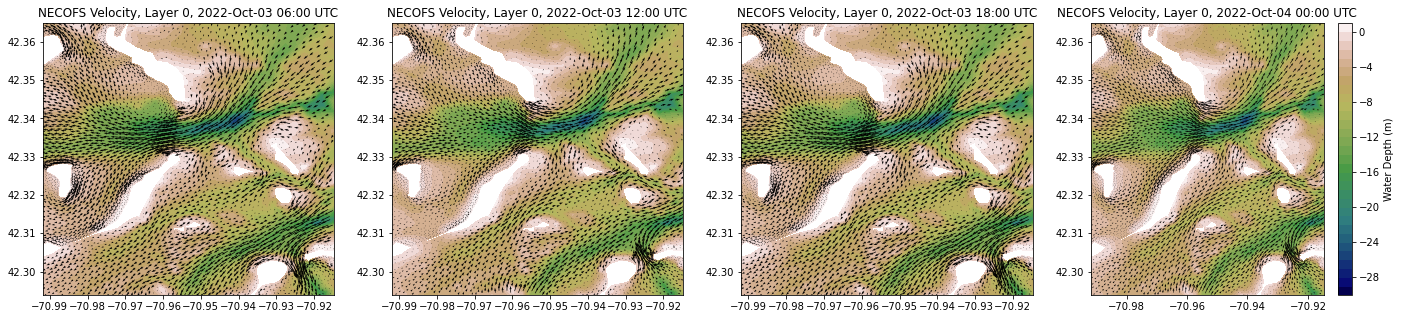

In [ ]:
# Calc number of subplots to generate
n_times = len(timestamps)

# Convert human-understandable timestamps to indices of the 'time' variable
itimes = [netCDF4.date2index(timestamp, nc.variables["time"], select = "nearest") for timestamp in timestamps]

fig, axs = plt.subplots(1,                          # Number of rows
                        n_times,                    # Number of columns
                        figsize=(6 * n_times, 5),   # Stretch the x-axis by the number of plots
                        squeeze=False)              # Squeeze is important. Else, will flatten the dimensions causing loop to fail

# For each timestamp
for i in range(n_times):
  # Plot to map to a subplot
  cf = plotMap(itimes[i], axs[0][i])

# Add colorbar
cbar=plt.colorbar(cf)
cbar.set_label('Water Depth (m)')

### Create an animated time series gif

**Generate a sequence of time indices**

In [ ]:
# Use number of time data points to get all indices
all_itimes = np.array(range(len(nc["time"][:])))

# Select to go from hourly to every 4th hour
selected_itimes = all_itimes[::4]
n_selected = len(selected_itimes)

print("Will plot {} timestamps".format(n_selected))

Will plot 37 timestamps


**Generate a sequence of output filenames**

In [ ]:
frame_filenames = ["velocity_frame_{}.png".format(i) for i in range(n_selected)]

In [ ]:
%%capture

# For each timestamp
for i, itime in enumerate(selected_itimes):

  # Plot to map to a subplot
  fig, ax = plt.subplots(figsize=(6,5));
  cf = plotMap(itime, ax);
  cbar=plt.colorbar(cf);
  cbar.set_label('Water Depth (m)');

  plt.savefig(frame_filenames[i]);
  plt.close()

**Check the current working directory to see the saved files**

In [ ]:
!ls

sample_data	       velocity_frame_20.png  velocity_frame_32.png
velocity_frame_0.png   velocity_frame_21.png  velocity_frame_33.png
velocity_frame_10.png  velocity_frame_22.png  velocity_frame_34.png
velocity_frame_11.png  velocity_frame_23.png  velocity_frame_35.png
velocity_frame_12.png  velocity_frame_24.png  velocity_frame_36.png
velocity_frame_13.png  velocity_frame_25.png  velocity_frame_3.png
velocity_frame_14.png  velocity_frame_26.png  velocity_frame_4.png
velocity_frame_15.png  velocity_frame_27.png  velocity_frame_5.png
velocity_frame_16.png  velocity_frame_28.png  velocity_frame_6.png
velocity_frame_17.png  velocity_frame_29.png  velocity_frame_7.png
velocity_frame_18.png  velocity_frame_2.png   velocity_frame_8.png
velocity_frame_19.png  velocity_frame_30.png  velocity_frame_9.png
velocity_frame_1.png   velocity_frame_31.png


**Inspect a single frame**

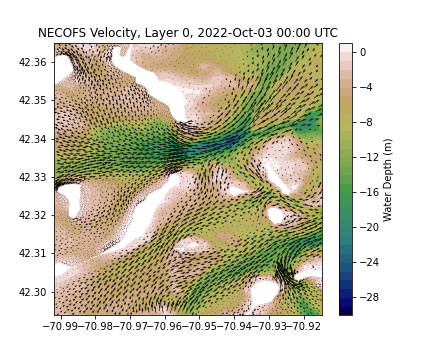

In [ ]:
from IPython.display import Image
Image('velocity_frame_0.png')

**Combine frames to create animated gif**

- Also possible to do this directly with python
- But I prefer to output all frames & combine after
- This way, I could load frames into an editor (i.e. Inkscape) for further customization

In [ ]:
!convert -delay 50 velocity_frame_*.png velocity_animation_wrong.gif

**Show the animation... but why is the frame order wrong?!**

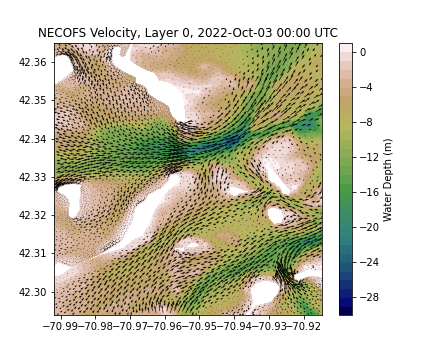

In [ ]:
Image('velocity_animation_wrong.gif')

**Try again, with correct numeric ordering**

In [ ]:
# Will rely on the `-v` option to get numeric ordering
!ls -v velocity_frame_*.png

velocity_frame_0.png   velocity_frame_13.png  velocity_frame_26.png
velocity_frame_1.png   velocity_frame_14.png  velocity_frame_27.png
velocity_frame_2.png   velocity_frame_15.png  velocity_frame_28.png
velocity_frame_3.png   velocity_frame_16.png  velocity_frame_29.png
velocity_frame_4.png   velocity_frame_17.png  velocity_frame_30.png
velocity_frame_5.png   velocity_frame_18.png  velocity_frame_31.png
velocity_frame_6.png   velocity_frame_19.png  velocity_frame_32.png
velocity_frame_7.png   velocity_frame_20.png  velocity_frame_33.png
velocity_frame_8.png   velocity_frame_21.png  velocity_frame_34.png
velocity_frame_9.png   velocity_frame_22.png  velocity_frame_35.png
velocity_frame_10.png  velocity_frame_23.png  velocity_frame_36.png
velocity_frame_11.png  velocity_frame_24.png
velocity_frame_12.png  velocity_frame_25.png


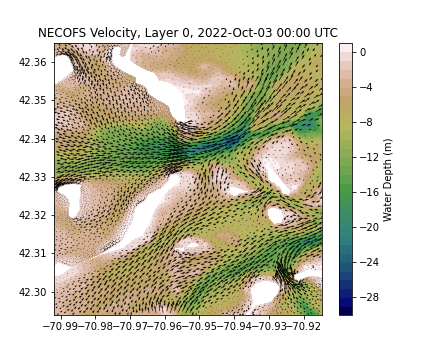

In [ ]:
!convert -delay 50 `ls -v velocity_frame_*.png` velocity_animation.gif
Image('velocity_animation.gif')

## Task 3: Plot time series data for point locations

- Given our station locations, plot time series data

**Find nearest (lat, lon) in dataset to the target station**

- Our list of stations was created manually (arbitrary coordinates)
- There is a discrete sequence of (lat, lon) coordinates in the NetCDF dataset
- Must find closest dataset (lat, lon) to target (lat, lon)

In [ ]:
def getNearestLocation(target_lat, target_lon, lats, lons):
  dist = np.sqrt((lats - target_lat)**2 + (lons - target_lon)**2)
  nearest_idx = dist.argmin()
  nearest_dist = dist.min()
  return nearest_idx, nearest_dist

In [ ]:
nearest = np.array([getNearestLocation(gdf_stations.iloc[i]["geometry"].y, gdf_stations.iloc[i]["geometry"].x, lat, lon) for i in range(len(gdf_stations))])

In [ ]:
gdf_stations["nearest_nc_idx"] = nearest[:, 0].astype("int")
gdf_stations["nearest_nc_distance"] = nearest[:, 1]

gdf_stations

Name                    geometry  nearest_nc_idx  nearest_nc_distance
0  station 0  POINT (-70.98187 42.31838)           71189             0.000408
1  station 1  POINT (-70.92479 42.30392)           57717             0.000583
2  station 2  POINT (-70.97041 42.35494)           66297             0.000368
3  station 3  POINT (-70.93512 42.33031)           51946             0.000484

In [ ]:
# Get salinity 
surface_salinity_idx = 0
salinity = nc["salinity"][:, surface_currents_idx, :]

In [ ]:
# Get all time steps salinity data at each station location
salinity_stations = salinity[:, gdf_stations["nearest_nc_idx"].values]

In [ ]:
# Create DataFrame where each row is a time step, each column a station
df_salinity = pd.DataFrame(salinity_stations)
df_salinity

# Column names from each stations
df_salinity.columns = gdf_stations["Name"].values

# Add column with time index
df_salinity["itime"] = nc["time"][:]

# Replace index with datetime object
df_salinity["datetime"] = netCDF4.num2date(df_salinity["itime"].values, nc.variables["time"].units, only_use_cftime_datetimes=False)
df_salinity = df_salinity.set_index("datetime")
df_salinity.index = pd.to_datetime(df_salinity.index)

df_salinity

station 0  station 1  station 2  station 3  \
datetime                                                              
2022-10-03 00:00:00.000  31.662470  31.929415  31.788439  31.878651   
2022-10-03 01:01:52.500  31.557346  31.927534  31.786989  31.898462   
2022-10-03 01:58:07.500  31.538092  31.924381  31.789867  31.914381   
2022-10-03 03:00:00.000  31.560898  31.922729  31.791933  31.914888   
2022-10-03 04:01:52.500  31.583504  31.930754  31.798185  31.908594   
...                            ...        ...        ...        ...   
2022-10-08 19:58:07.500  31.548859  31.929567  31.732544  31.892729   
2022-10-08 21:00:00.000  31.528894  31.922482  31.731852  31.897833   
2022-10-08 22:01:52.500  31.603720  31.926714  31.727592  31.753935   
2022-10-08 22:58:07.500  31.506783  31.907129  31.747793  31.786327   
2022-10-09 00:00:00.000  31.424459  31.904165  31.770454  31.794289   

                                itime  
datetime                               
2022-10-03 00:00:00.000  59855.000000  
2022-10-03 01:01:52.500  59855.042969  
2022-10-03 01:58:07.500  59855.082031  
2022-10-03 03:00:00.000  59855.125000  
2022-10-03 04:01:52.500  59855.167969  
...                               ...  
2022-10-08 19:58:07.500  59860.832031  
2022-10-08 21:00:00.000  59860.875000  
2022-10-08 22:01:52.500  59860.917969  
2022-10-08 22:58:07.500  59860.957031  
2022-10-09 00:00:00.000  59861.000000  

[145 rows x 5 columns]

**Plot time series**

Text(0, 0.5, 'Salinity')

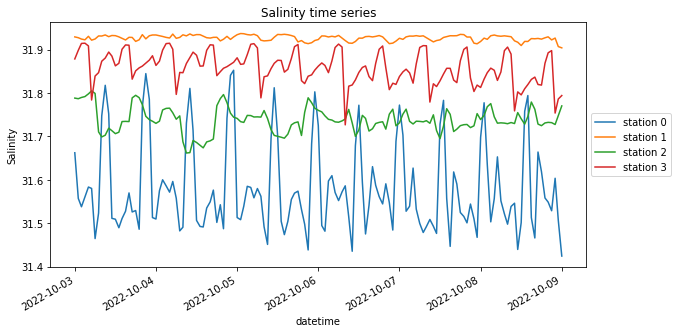

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
df_salinity.plot(y=gdf_stations["Name"].values, ax=ax)

# Move the legend outside the axis
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.title("Salinity time series")
plt.ylabel("Salinity")

**Rolling means**

Plot the 6-hour rolling average

Text(0, 0.5, 'Salinity')

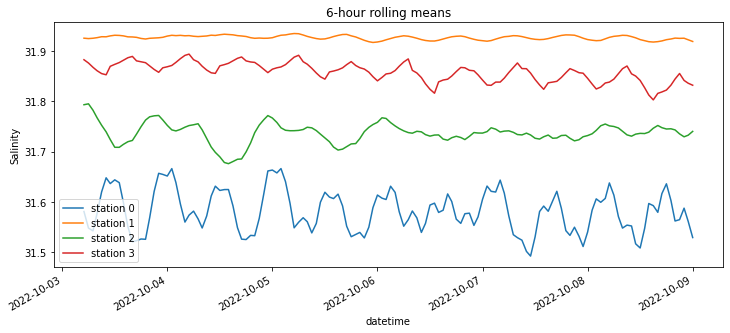

In [ ]:
# Calculate rolling values
df_salinity_rolling = df_salinity.rolling(6).mean()

# Plot rolling mean
fig, ax = plt.subplots(figsize=(12,5))
df_salinity_rolling.plot(y=gdf_stations["Name"].values, ax=ax)
plt.title("6-hour rolling means")
plt.ylabel("Salinity")

### Plot pandas daily means

Text(0, 0.5, 'Salinity')

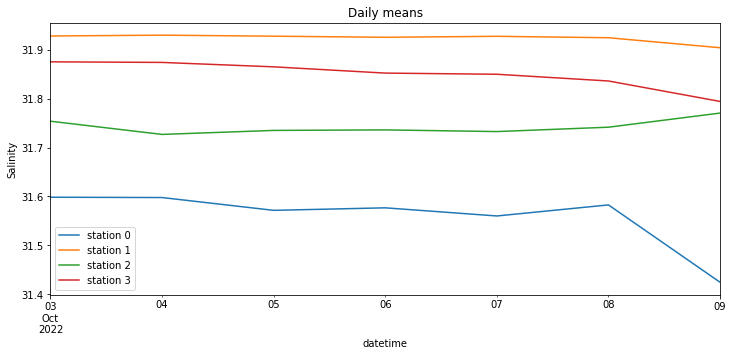

In [ ]:
# Resample to daily
df_salinity_daily = df_salinity.resample("D").mean()

# Plot rolling mean
fig, ax = plt.subplots(figsize=(12,5))
df_salinity_daily.plot(y=gdf_stations["Name"].values, ax=ax)
plt.title("Daily means")
plt.ylabel("Salinity")

## Task 4: Create an interactive map

- The `folium` library is an easy way to create interactive maps
- Here, I just show a tiny example to give a taste of what can be done
- See the documentation for many examples: https://python-visualization.github.io/folium/quickstart.html 

**Initialize map with center location**

In [ ]:
# Calculate a map center location
center_lat = float(gdf_bounds[gdf_bounds["bounds"] == "lower_left"]["geometry"].y) + \
    (float(gdf_bounds[gdf_bounds["bounds"] == "upper_left"]["geometry"].y) - \
    float(gdf_bounds[gdf_bounds["bounds"] == "lower_left"]["geometry"].y)) * 0.5
center_lon = float(gdf_bounds[gdf_bounds["bounds"] == "upper_left"]["geometry"].x) + \
    (float(gdf_bounds[gdf_bounds["bounds"] == "upper_right"]["geometry"].x) - \
    float(gdf_bounds[gdf_bounds["bounds"] == "lower_left"]["geometry"].x)) * 0.5

**Calculate data to add to icon pop ups**

When you click point on the map, can get extra information

In [ ]:
gdf_stations["salinity_mean"] = df_salinity.mean()
gdf_stations["salinity_min"] = df_salinity.min()
gdf_stations["salinity_max"] = df_salinity.max()

gdf_stations

Name                    geometry  nearest_nc_idx  nearest_nc_distance  \
0  station 0  POINT (-70.98187 42.31838)           71189             0.000408   
1  station 1  POINT (-70.92479 42.30392)           57717             0.000583   
2  station 2  POINT (-70.97041 42.35494)           66297             0.000368   
3  station 3  POINT (-70.93512 42.33031)           51946             0.000484   

   salinity_mean  salinity_min  salinity_max  
0            NaN           NaN           NaN  
1            NaN           NaN           NaN  
2            NaN           NaN           NaN  
3            NaN           NaN           NaN

**Add stations to map**

In [ ]:
# Initialize map
m = folium.Map((center_lat, center_lon), zoom_start=12)

# Add points to map
for i in range(len(gdf_stations)):
  station = gdf_stations.iloc[i]

  name = station["Name"]

  lat = station["geometry"].y
  lon = station["geometry"].x

  popup = "Salinity <br> min:{:.3f}ppm <br> mean:{:.3f}ppm <br> max:{:.3f}ppm".format(station["salinity_min"], station["salinity_mean"], station["salinity_max"])
  folium.Marker(
      [lat, lon],
      icon=folium.Icon(color="purple", icon="info-sign"),
      popup=popup,
      tooltip=name
  ).add_to(m)

In [ ]:
m

**Save map as HTML webpage**

In [ ]:
m.save("stations.html")